In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
from glob import glob
import os
from astropy.io import fits

pscale = 1000 * 23/512 # mas/pixel, (Yinuo's email said 45mas/px, but I think the FOV is 23x23 arcsec for a 512x512 image?)

import WR_Geom_Model as gm
import WR_binaries as wrb

# Start by analysing projection effects with the model

0.4


<Axes: xlabel='Relative RA (")', ylabel='Relative Dec (")'>

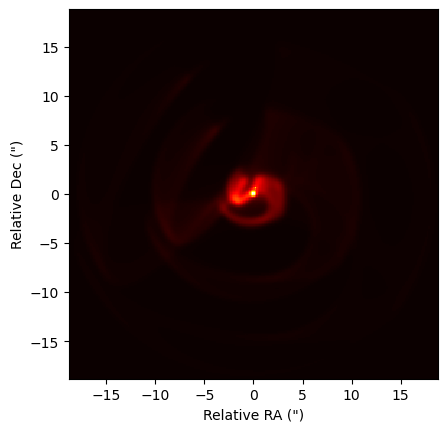

In [2]:
apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
apep['phase'] = 0.4
print(apep['phase'])
shells = 3
model_func = gm.gui_funcs[shells-1]

particles, weights = model_func(apep)
X, Y, H = gm.smooth_histogram2d(particles, weights, apep)
# print(time.time() - t1)
H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
gm.plot_spiral(X, Y, H)


### Left to right ridge shell evolution

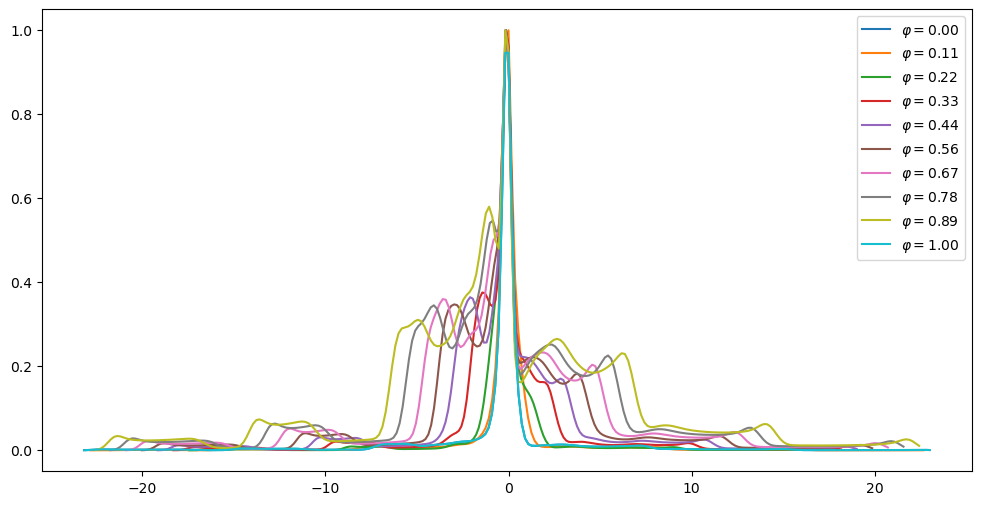

In [3]:
apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
# apep['phase'] = 0.6
shells = 3
model_func = gm.gui_funcs[shells-1]

fig, ax = plt.subplots(figsize=(12, 6))

for phase in np.linspace(0, 1, 10):
    apep['phase'] = phase
    particles, weights = model_func(apep)
    X, Y, H = gm.smooth_histogram2d(particles, weights, apep)
    # print(time.time() - t1)
    H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
#     gm.plot_spiral(X, Y, H)
    ax.plot(X[0, :-1], H[len(X[0, :])//2, :], label=fr'$\varphi = {phase:.2f}$')
ax.legend()

### Bottom to top shell evolution

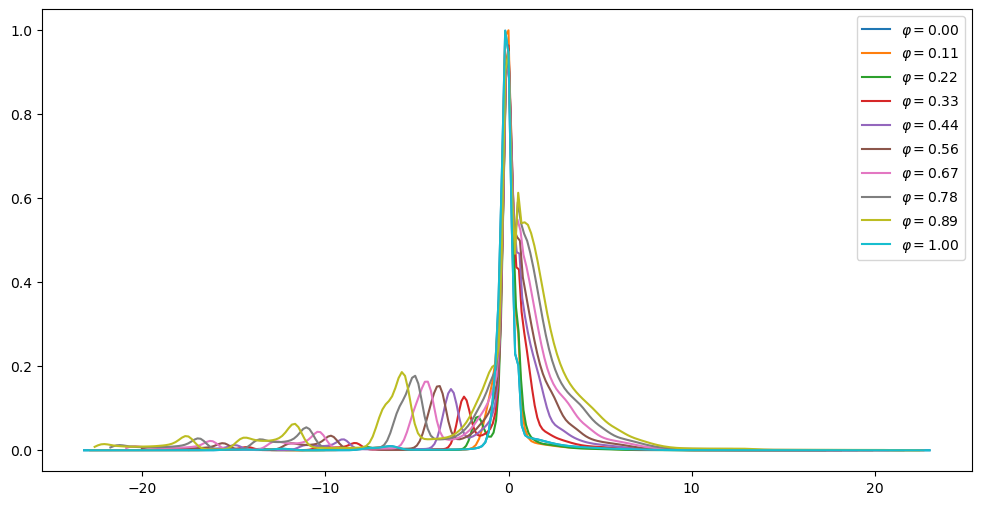

In [4]:
apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
# apep['phase'] = 0.6
shells = 3
model_func = gm.gui_funcs[shells-1]

fig, ax = plt.subplots(figsize=(12, 6))

for phase in np.linspace(0, 1, 10):
    apep['phase'] = phase
    particles, weights = model_func(apep)
    X, Y, H = gm.smooth_histogram2d(particles, weights, apep)
    # print(time.time() - t1)
    H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
#     gm.plot_spiral(X, Y, H)
    ax.plot(Y[:-1, 0], H[:, len(X[0, :])//2], label=fr'$\varphi = {phase:.2f}$')
ax.legend()

### Now to play with the data

In [5]:
## directory = "Data\\JWST\\MAST_2024-07-29T2157\\JWST"
# # fname = glob(directory+"\\jw05842001001_03101_00001_mirimage\\*_cal.fits")[0]
# fname = glob(directory+"\\jw05842-o001_t001_miri_f2550w\\*_i2d.fits")[0]

# fname

directory = "Data\\VLT"
fnames = glob(directory + "\\*.fits")

vlt_years = [2016, 2017, 2018, 2024]
vlt_data = {}
colours = {2016:"tab:blue", 2017:"tab:green", 2018:"tab:red", 2024:"tab:purple"}

for i, fname in enumerate(fnames):
    vlt_data[vlt_years[i]] = fits.open(fname)

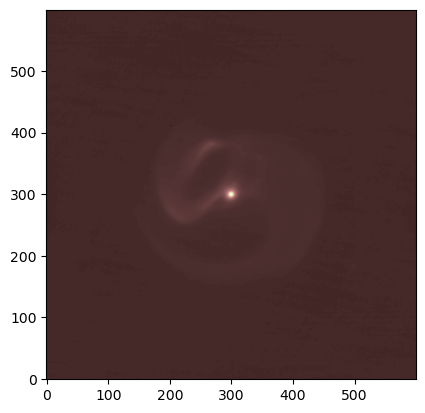

In [36]:
fig, ax = plt.subplots()
ax.imshow(vlt_data[2024][0].data, cmap='pink')
ax.invert_yaxis()

### Left-to-right Ridge Profile

600


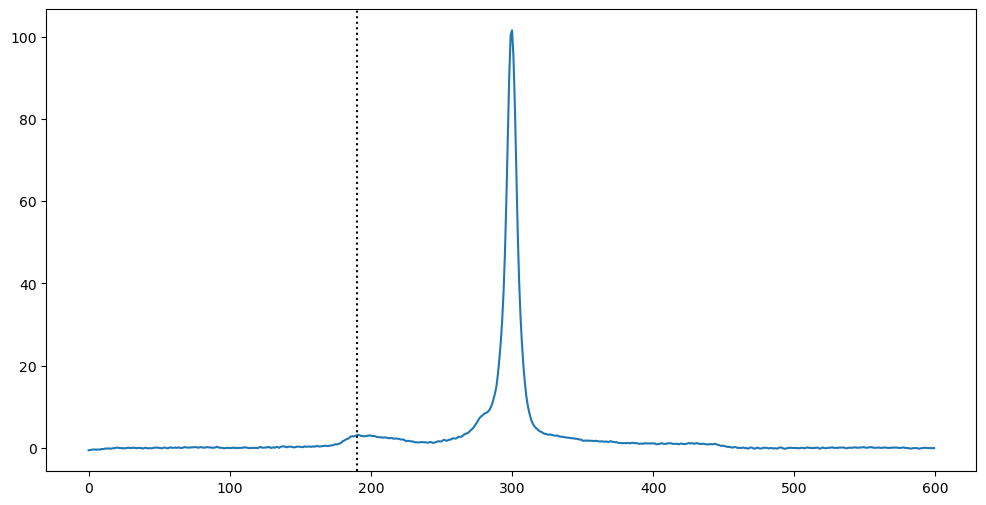

In [7]:
brightnesses = vlt_data[2024][0].data[::-1, 300]
brightnesses = vlt_data[2024][0].data[300, :]
print(len(brightnesses))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(brightnesses)
ax.axvline(190, ls=':', c='k')

### Bottom-to-top ridge profile

600


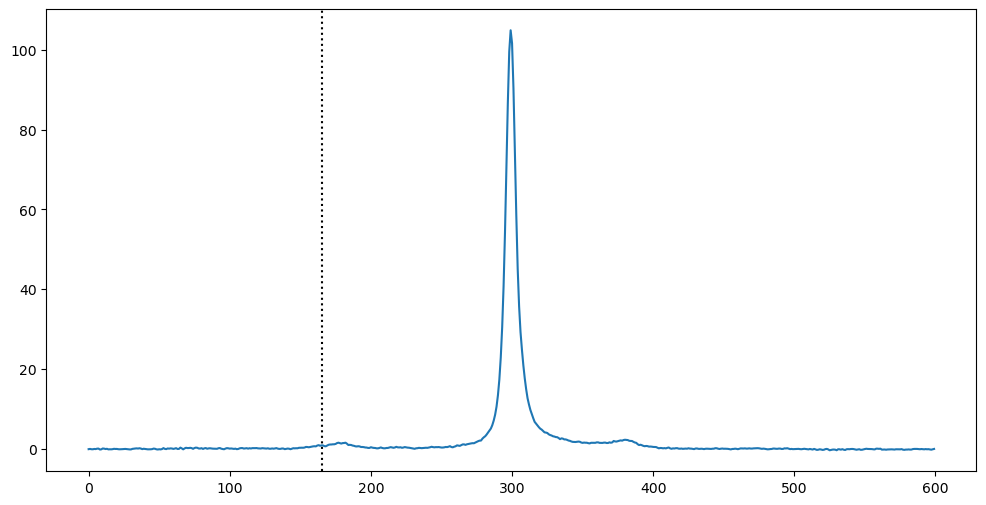

In [32]:
brightnesses = vlt_data[2024][0].data[:, 300]
print(len(brightnesses))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(brightnesses)
ax.axvline(165, ls=':', c='k')

[Text(0.5, 1.0, 'Left Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

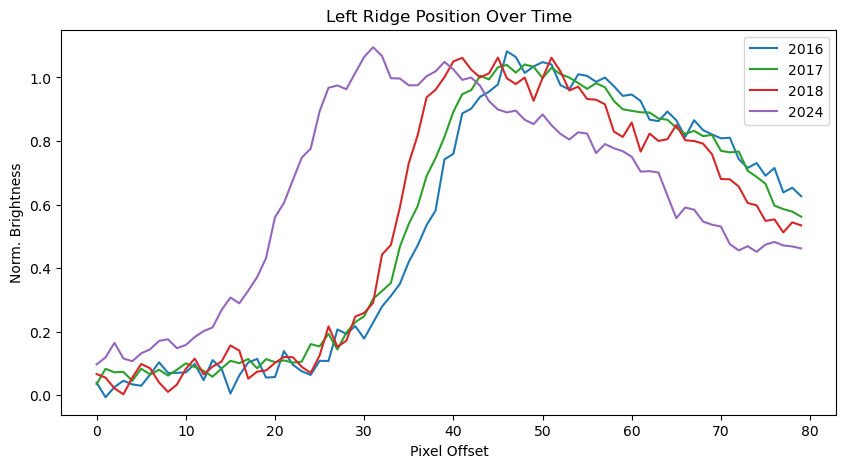

In [9]:
left_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][0].data[300, 160:240]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    left_ridges[key] = epoch_data / denumerator
    left_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(left_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Left Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

[Text(0.5, 1.0, 'Left Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

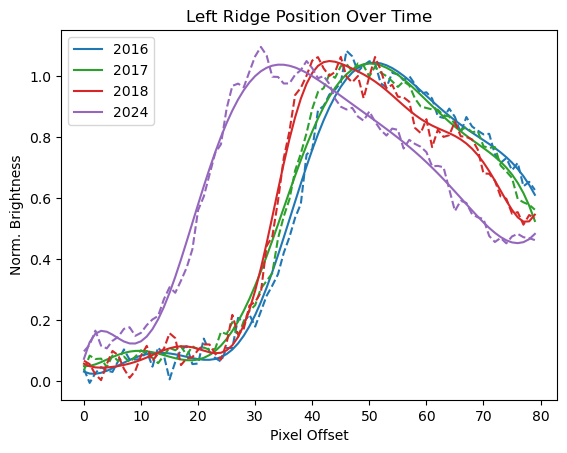

In [10]:
from scipy.interpolate import UnivariateSpline

left_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    left_ridge_splines[key] = UnivariateSpline(left_ridges['x'], left_ridges[key], k=5, s=0.1, ext=3)
    ax.plot(left_ridges['x'], left_ridge_splines[key](left_ridges['x']), c=colours[key], label=str(key))
    ax.plot(left_ridges['x'], left_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Left Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

In [11]:
# from scipy.optimize import least_squares

# use_left_ridge_spline = left_ridge_splines[2016]
# min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

# # def residual_error_squared(a, x, y):
# #     shifted_x = x - a
# #     if shifted_x < min_val or shifted_x > max_val:
# #         return 0
# #     error = use_left_ridge_spline(shifed_x) - y
# #     return error

# def residual_error_squared(a, x, y):
#     shifted_x = x - a
#     residuals = np.zeros(len(x))
#     for i in range(len(x)):
#         if shifted_x[i] < min_val or shifted_x[i] > max_val:
#             residuals[i] = np.nan
#         else:
#             residuals[i] = use_left_ridge_spline(shifted_x[i]) - y[i]
#     mask = ~np.isnan(residuals)
#     return residuals[mask]

# test_data = left_ridges[2024]

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
# test_shift = result.x
# # [test_shift], _ = curve_fit(shift_edge, ydata=test_data, xdata=left_ridges['x'], p0=(30))
# print(test_shift)
# fig, ax = plt.subplots()
# ax.plot(left_ridges['x'], test_data)
# ax.plot(left_ridges['x'], shift_edge(left_ridges['x'], test_shift))

-16.39369832288724


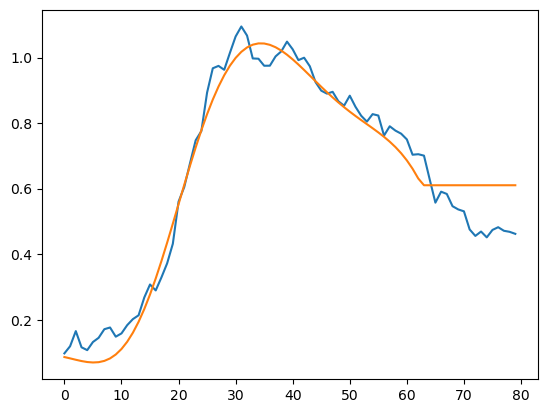

In [12]:
from scipy.optimize import least_squares, curve_fit


use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
#     if x - a < min_val or x - a > max_val:
#         return np.nan
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

test_data = left_ridges[2024]

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
[test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
print(test_shift)
fig, ax = plt.subplots()
ax.plot(left_ridges['x'], test_data)
ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))

[  0.          -1.60513112  -3.67255127 -16.39369832]


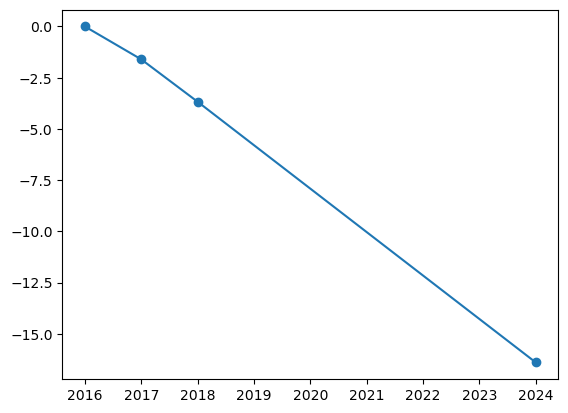

In [13]:
use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
left_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    [shift], _ = curve_fit(shifted_spline, ydata=left_ridges[year], xdata=left_ridges['x'], p0=(-10))
    left_ridge_shifts[i+1] = shift
    
print(left_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, left_ridge_shifts, marker='o')

Expansion of left ridge is 91.21 mas/yr
Hence the windspeed from the left edge is 1038.5 km/s


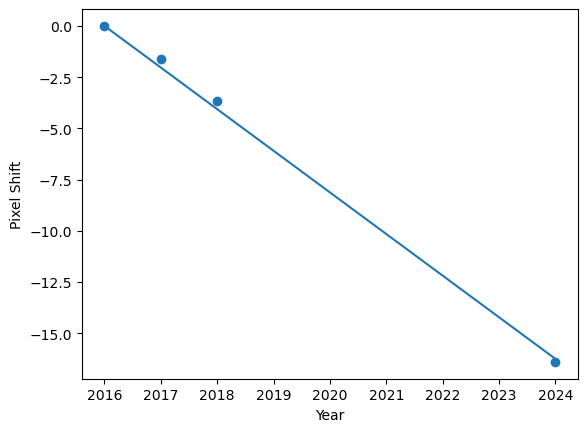

In [14]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=left_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, left_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

left_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
left_ridge_windspeed = np.tan(np.deg2rad(left_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of left ridge is {left_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the left edge is {left_ridge_windspeed:.1f} km/s")

# Try again but with a more sophisticated fitting procedure
## Start with left ridge
The previous way included the spline even when out of bounds of the original data. This new way doesn't try to solve the least squares in that regime.

[-1.55482068]
[-3.49999819]
[-16.18133556]


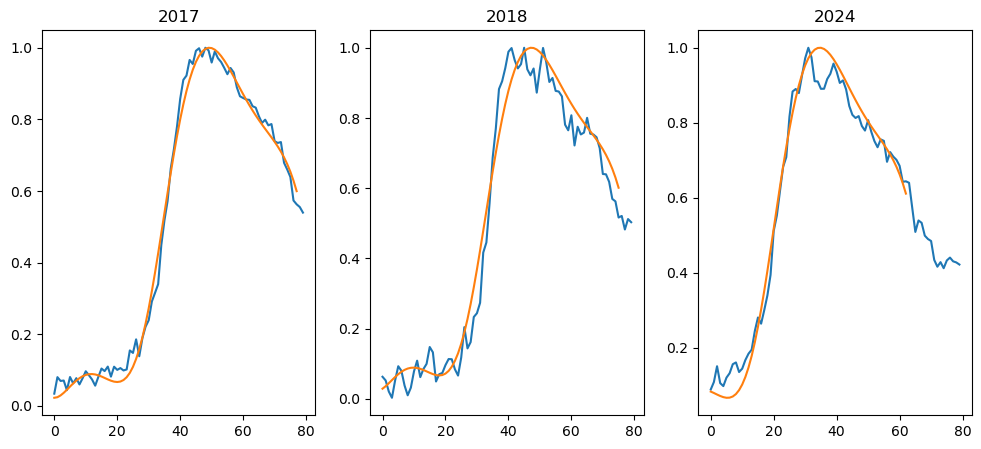

In [15]:
from scipy.optimize import least_squares, curve_fit, minimize


use_left_ridge_spline = left_ridge_splines[2016]
min_x, max_x = min(left_ridges['x']), max(left_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_left_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)


fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = left_ridges[year]

    # # result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
    # [test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
    # print(test_shift)
    # fig, ax = plt.subplots()
    # ax.plot(left_ridges['x'], test_data)
    # ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))
    result = minimize(least_sq_err, -5, args=(test_data, left_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = left_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (left_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

#     fig, ax = plt.subplots()
    spl_y = use_left_ridge_spline(shifted_x[use_args])
    axes[i].plot(left_ridges['x'], test_data / max(test_data))
    axes[i].plot(left_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))


[  0.          -1.55482269  -3.49999938 -16.18133558]


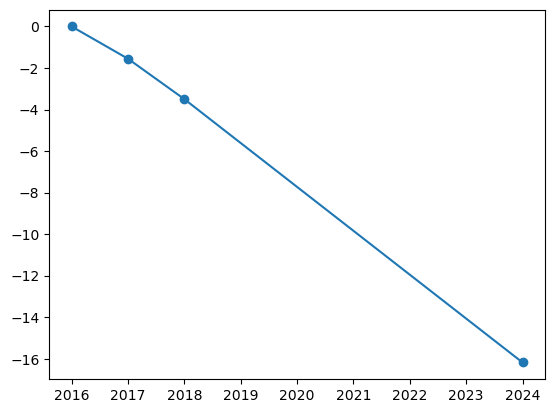

In [16]:
use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
left_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, -10, args=(left_ridges[year], left_ridges['x']), method='Powell')
    left_ridge_shifts[i+1] = result.x[0]
    
print(left_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, left_ridge_shifts, marker='o')

Expansion of left ridge is 89.85 mas/yr
Hence the windspeed from the left edge is 1023.0 km/s


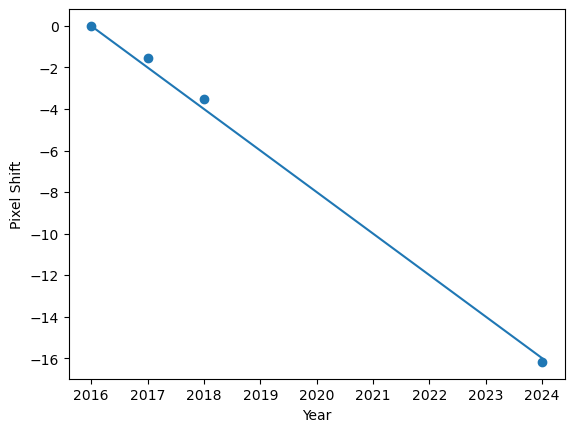

In [17]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=left_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, left_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

left_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
left_ridge_windspeed = np.tan(np.deg2rad(left_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of left ridge is {left_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the left edge is {left_ridge_windspeed:.1f} km/s")

## Now for top ridge

[Text(0.5, 1.0, 'Top Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

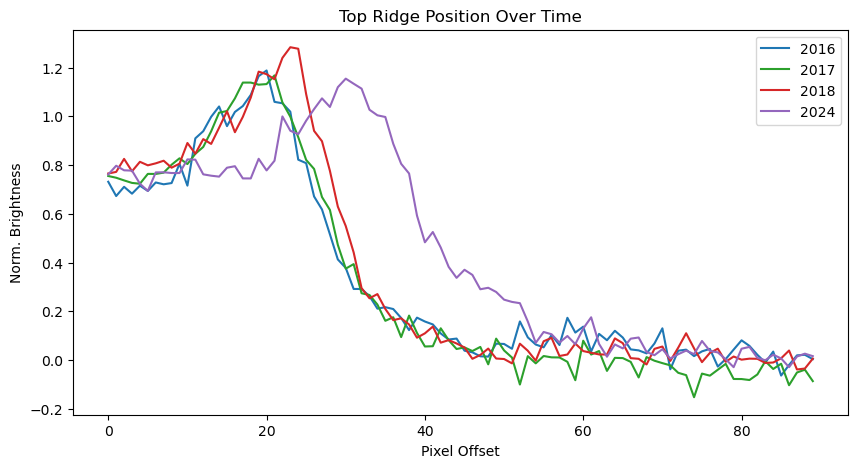

In [18]:
top_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][0].data[350:440, 300]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    top_ridges[key] = epoch_data / denumerator
    top_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(top_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Top Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

[Text(0.5, 1.0, 'Top Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

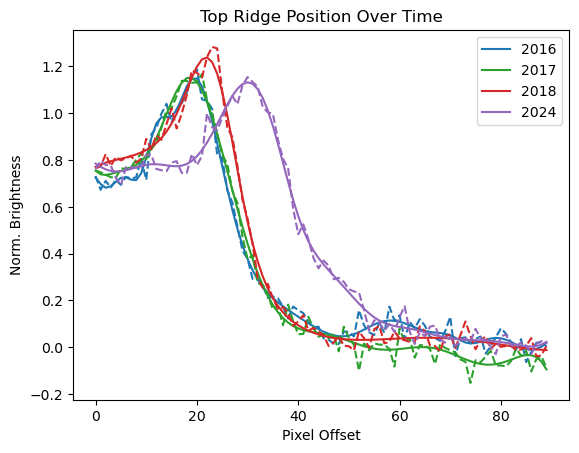

In [19]:
from scipy.interpolate import UnivariateSpline

top_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    top_ridge_splines[key] = UnivariateSpline(top_ridges['x'], top_ridges[key], k=5, s=0.1, ext=3)
    ax.plot(top_ridges['x'], top_ridge_splines[key](top_ridges['x']), c=colours[key], label=str(key))
    ax.plot(top_ridges['x'], top_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Top Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

[0.38592394]
[1.87917981]
[11.97589249]


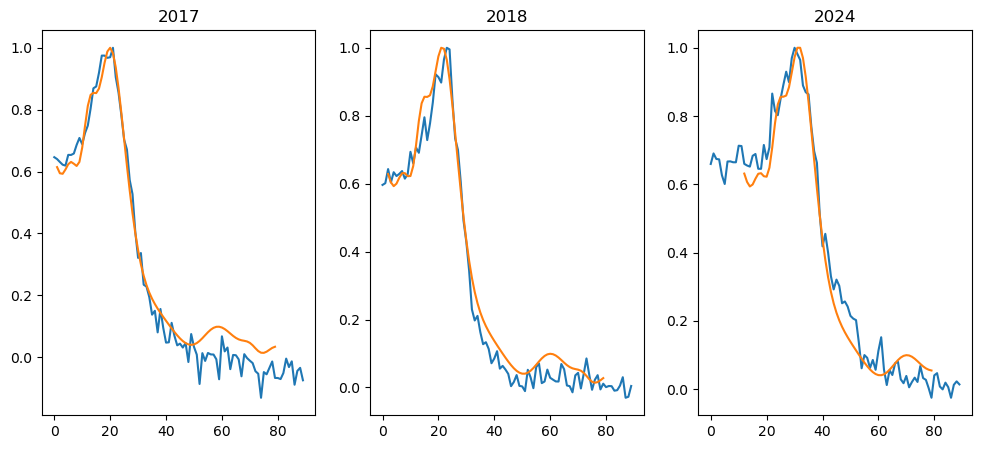

In [20]:
from scipy.optimize import least_squares, curve_fit, minimize


use_top_ridge_spline = top_ridge_splines[2016]
min_x, max_x = min(top_ridges['x']), max(top_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_top_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = top_ridges[year]

    # # result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
    # [test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
    # print(test_shift)
    # fig, ax = plt.subplots()
    # ax.plot(left_ridges['x'], test_data)
    # ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))
    result = minimize(least_sq_err, -5, args=(test_data, top_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = top_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (top_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

#     fig, ax = plt.subplots()
    spl_y = use_top_ridge_spline(shifted_x[use_args])
    axes[i].plot(top_ridges['x'], test_data / max(test_data))
    axes[i].plot(top_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))

# fig, ax = plt.subplots()
# shift_range = np.linspace(-20, 5, 500)
# chisqs = np.array([least_sq_err(shift, test_data, top_ridges['x']) for shift in shift_range])
# ax.plot(shift_range, chisqs)

[ 0.          0.38592394  1.87917981 11.97589249]


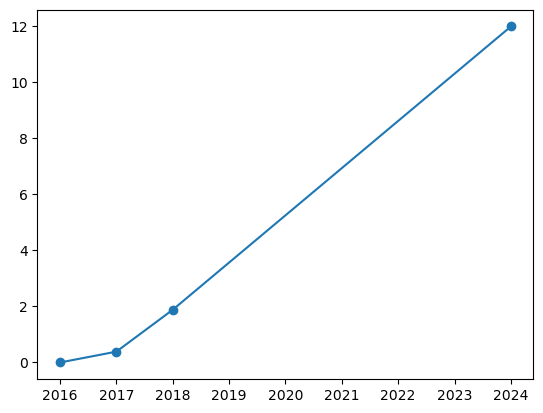

In [21]:
def shifted_spline_sub(x, a):
    return use_top_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
top_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, -5, args=(top_ridges[year], top_ridges['x']), method='Powell')
    top_ridge_shifts[i+1] = result.x[0]
    
print(top_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, top_ridge_shifts, marker='o')

Expansion of top ridge is 65.07 mas/yr
Hence the windspeed from the top edge is 740.9 km/s


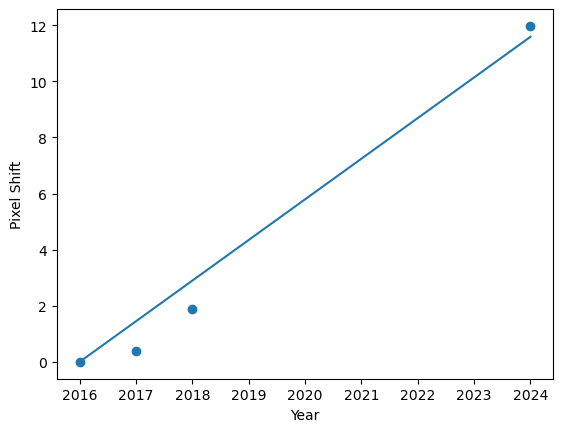

In [22]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=top_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, top_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

top_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
top_ridge_windspeed = np.tan(np.deg2rad(top_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of top ridge is {top_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the top edge is {top_ridge_windspeed:.1f} km/s")

## Now for the right ridge.

[0.95369586]
[2.84906164]
[13.9999936]
[ 0.          0.95369913  2.84903043 13.99999908]
Expansion of right ridge is 77.25 mas/yr
Hence the windspeed from the right edge is 879.5 km/s


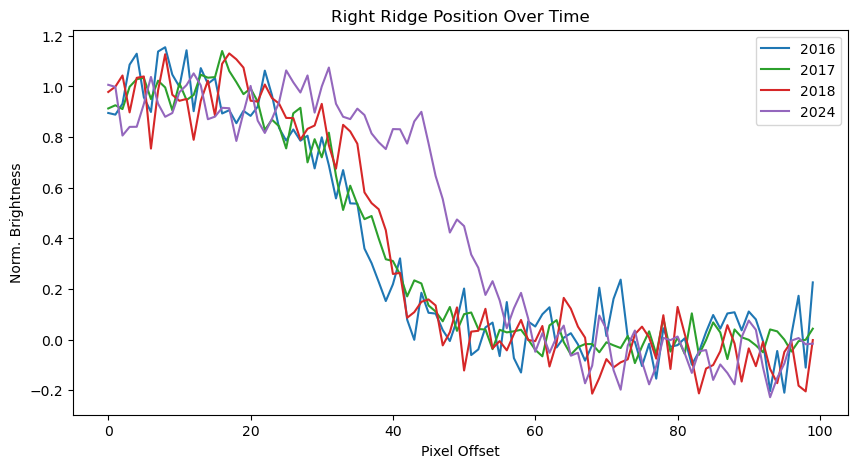

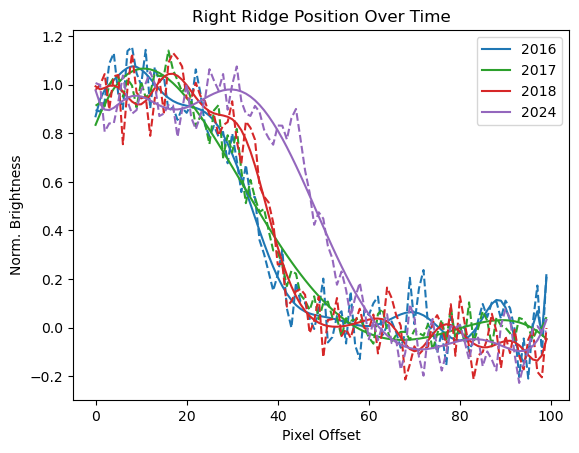

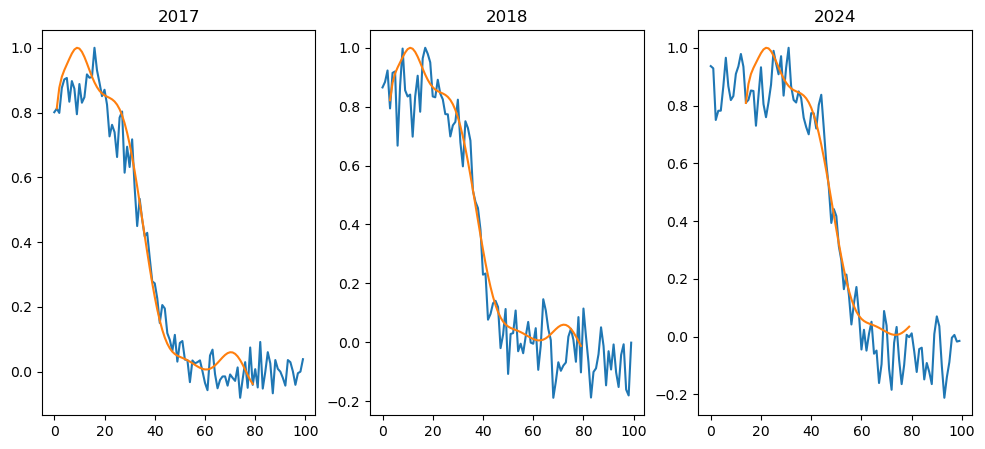

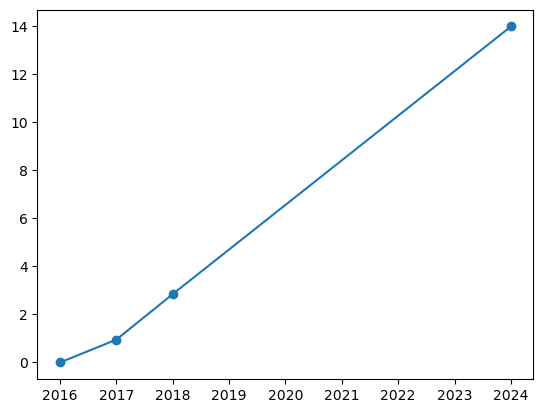

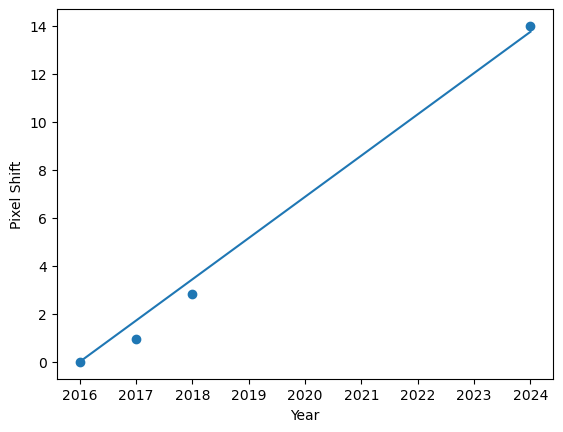

In [23]:
right_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][0].data[300, 400:500]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    right_ridges[key] = epoch_data / denumerator
    right_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(right_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Right Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.interpolate import UnivariateSpline

right_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    right_ridge_splines[key] = UnivariateSpline(right_ridges['x'], right_ridges[key], k=5, s=0.6, ext=3)
    ax.plot(right_ridges['x'], right_ridge_splines[key](right_ridges['x']), c=colours[key], label=str(key))
    ax.plot(right_ridges['x'], right_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Right Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.optimize import least_squares, curve_fit, minimize


use_right_ridge_spline = right_ridge_splines[2016]
min_x, max_x = min(right_ridges['x']), max(right_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_right_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = right_ridges[year]
    result = minimize(least_sq_err, -5, args=(test_data, right_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = right_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (right_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

    spl_y = use_right_ridge_spline(shifted_x[use_args])
    axes[i].plot(right_ridges['x'], test_data / max(test_data))
    axes[i].plot(right_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))






def shifted_spline_sub(x, a):
    return use_right_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
right_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, 5, args=(right_ridges[year], right_ridges['x']), method='Powell')
    right_ridge_shifts[i+1] = result.x[0]
    
print(right_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, right_ridge_shifts, marker='o')




xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=right_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, right_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

right_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
right_ridge_windspeed = np.tan(np.deg2rad(right_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of right ridge is {right_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the right edge is {right_ridge_windspeed:.1f} km/s")

## Finally the bottom ridge

[-1.56586812]
[-1.96369409]
[-12.34088585]
[  0.          -1.56586812  -1.96369409 -12.34088585]
Expansion of bottom ridge is 67.85 mas/yr
Hence the windspeed from the bottom edge is 772.6 km/s


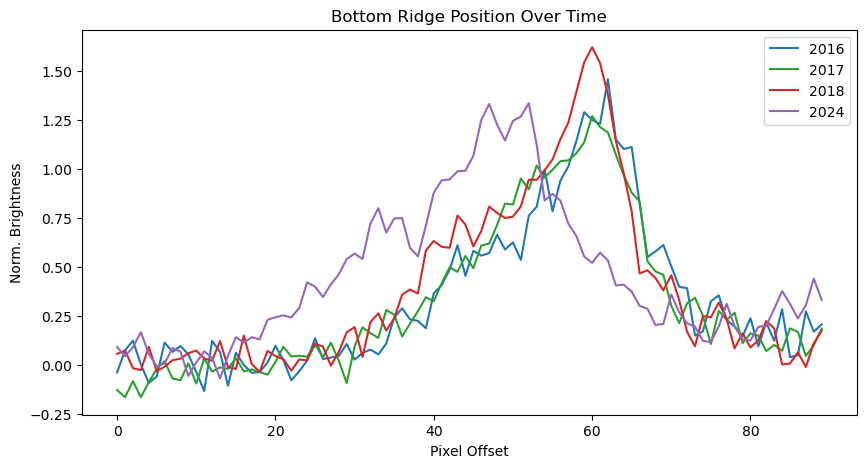

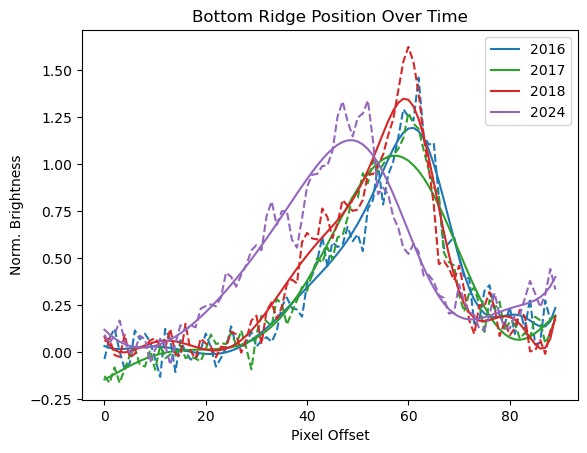

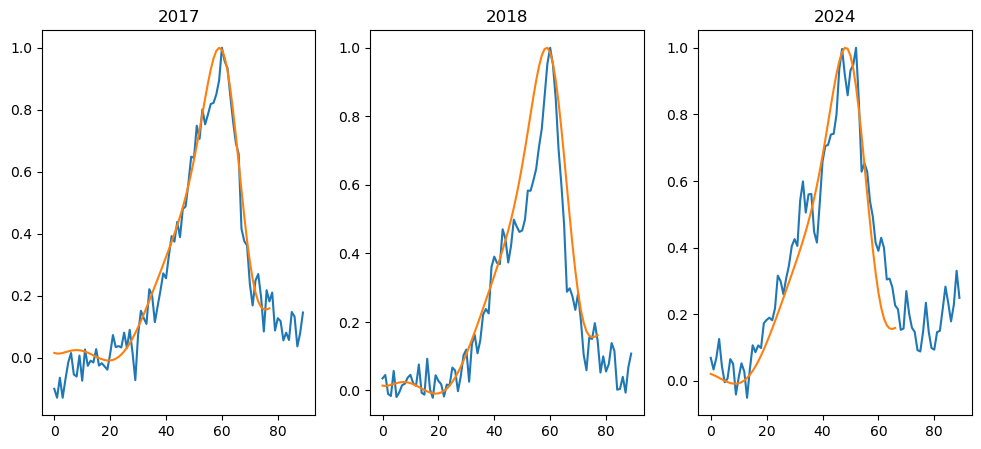

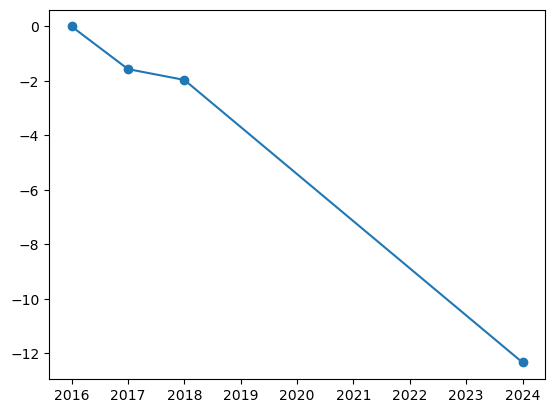

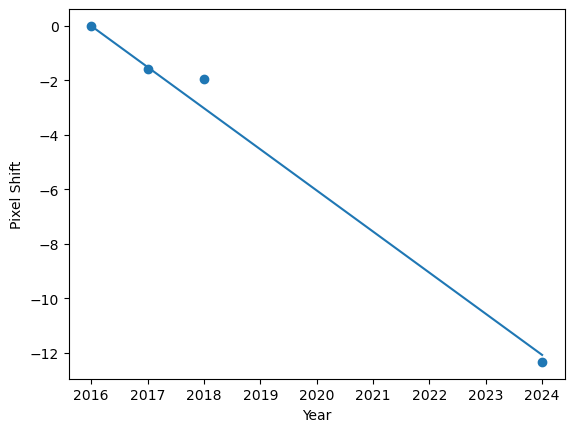

In [24]:
bottom_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][0].data[130:220, 300]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    bottom_ridges[key] = epoch_data / denumerator
    bottom_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(bottom_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Bottom Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.interpolate import UnivariateSpline

bottom_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    bottom_ridge_splines[key] = UnivariateSpline(bottom_ridges['x'], bottom_ridges[key], k=5, s=0.7, ext=3)
    ax.plot(bottom_ridges['x'], bottom_ridge_splines[key](bottom_ridges['x']), c=colours[key], label=str(key))
    ax.plot(bottom_ridges['x'], bottom_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Bottom Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.optimize import least_squares, curve_fit, minimize


use_bottom_ridge_spline = bottom_ridge_splines[2016]
min_x, max_x = min(bottom_ridges['x']), max(bottom_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_bottom_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = bottom_ridges[year]

    # # result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
    # [test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
    # print(test_shift)
    # fig, ax = plt.subplots()
    # ax.plot(left_ridges['x'], test_data)
    # ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))
    result = minimize(least_sq_err, -5, args=(test_data, bottom_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = bottom_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (bottom_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

#     fig, ax = plt.subplots()
    spl_y = use_bottom_ridge_spline(shifted_x[use_args])
    axes[i].plot(bottom_ridges['x'], test_data / max(test_data))
    axes[i].plot(bottom_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))






def shifted_spline_sub(x, a):
    return use_bottom_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
bottom_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, -5, args=(bottom_ridges[year], bottom_ridges['x']), method='Powell')
    bottom_ridge_shifts[i+1] = result.x[0]
    
print(bottom_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, bottom_ridge_shifts, marker='o')




xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=bottom_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, bottom_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

bottom_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
bottom_ridge_windspeed = np.tan(np.deg2rad(bottom_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of bottom ridge is {bottom_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the bottom edge is {bottom_ridge_windspeed:.1f} km/s")

## Now for JWST images

Filename: Data\JWST\MAST_2024-07-29T2157\JWST\jw05842-o001_t001_miri_f2550w\jw05842-o001_t001_miri_f2550w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  SCI           1 ImageHDU        75   (1204, 1160)   float32   
  2  ERR           1 ImageHDU        10   (1204, 1160)   float32   
  3  CON           1 ImageHDU        10   (1204, 1160, 1)   int32   
  4  WHT           1 ImageHDU         9   (1204, 1160)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (1204, 1160)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (1204, 1160)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (1204, 1160)   float32   
  8  HDRTAB        1 BinTableHDU    840   12R x 415C   [23A, 5A, 3A, 48A, 7A, 13A, 3A, 5A, 6A, 7A, 10A, 4A, L, D, D, D, D, 32A, 50A, 42A, 10A, 2A, D, 33A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 2A, L, 12A, 4A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 15A, 15A, 5A, D, D, D, D, D

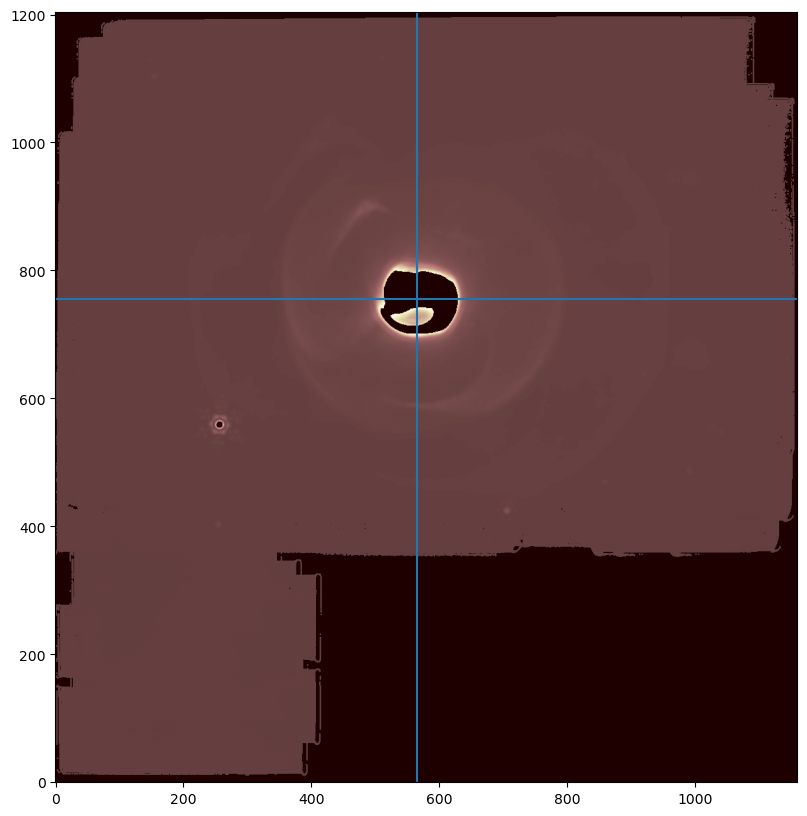

In [25]:
jwst_directory = "Data\\JWST\\MAST_2024-07-29T2157\\JWST"
# fname = glob(directory+"\\jw05842001001_03101_00001_mirimage\\*_cal.fits")[0]
jwst_fname = glob(jwst_directory+"\\jw05842-o001_t001_miri_f2550w\\*_i2d.fits")[0]

jwst_data = fits.open(jwst_fname)
print(jwst_data.info())

print(jwst_data[1].data)

jwst_image = jwst_data[1].data.T[:, ::-1]

# for i in range(2, len(jwst_data)-2):
#     print(i)
#     jwst_image += jwst_data[i].data.T[:, ::-1].reshape(jwst_image.shape)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(jwst_image, cmap='pink')
ax.invert_yaxis()

jwst_center_x = 565
jwst_center_y = 755
ax.axvline(jwst_center_x)
ax.axhline(jwst_center_y)

In [26]:
jwst_pscale = np.sqrt(jwst_data[1].header['PIXAR_A2']) * 1000
jwst_data[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-07-24T17:34:35.235' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw05842-o001_t001_miri_f2550w_i2d.fits' / Name of the file           
SDP_VER = '2024_1a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-066'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '9.3     '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC30   '        

Period estimate from bottom ridge shell separation and VISIR expansion is 253.36 years.


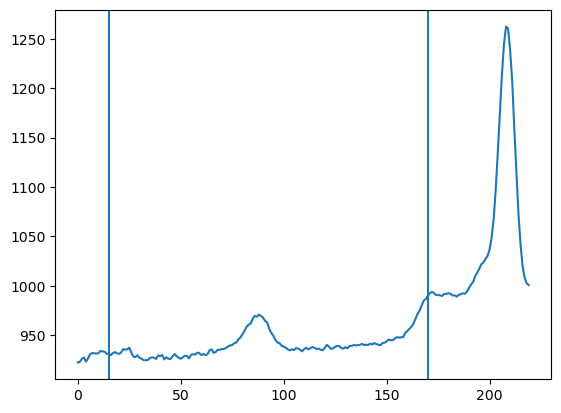

In [40]:
fig, ax = plt.subplots()
brightness_bottom = jwst_image[:, jwst_center_x][380:600]
ax.plot(np.arange(len(brightness_bottom)), brightness_bottom)

first_peak_bottom = np.argmax(brightness_bottom[:100])
first_peak_bottom = 65
first_peak_bottom = 15
second_peak_bottom = np.argmax(brightness_bottom)
second_peak_bottom = 170

ax.axvline(first_peak_bottom)
ax.axvline(second_peak_bottom)

delta_pixels_bottom = second_peak_bottom - first_peak_bottom

delta_angle_bottom = delta_pixels_bottom * jwst_pscale  # mas

delta_year_bottom = delta_angle_bottom / bottom_ridge_expansion
print(f"Period estimate from bottom ridge shell separation and VISIR expansion is {delta_year_bottom:.2f} years.")

Period estimate from left ridge shell separation and VISIR expansion is 246.88 years.


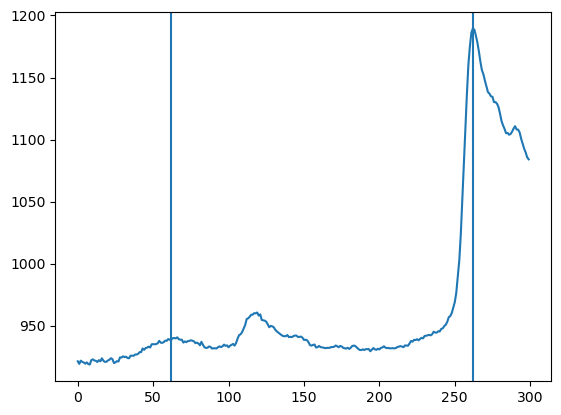

In [28]:
fig, ax = plt.subplots()
brightness_left = jwst_image[jwst_center_y, :][100:400]
ax.plot(np.arange(len(brightness_left)), brightness_left)

first_peak_left = np.argmax(brightness_left[:100])
first_peak_left = 62
second_peak_left = np.argmax(brightness_left)
second_peak_left = 262

ax.axvline(first_peak_left)
ax.axvline(second_peak_left)

delta_pixel_left = second_peak_left - first_peak_left

delta_angle_left = delta_pixel_left * jwst_pscale  # mas

delta_year_left = delta_angle_left / left_ridge_expansion
print(f"Period estimate from left ridge shell separation and VISIR expansion is {delta_year_left:.2f} years.")

Period estimate from right ridge shell separation and VISIR expansion is 242.64 years.


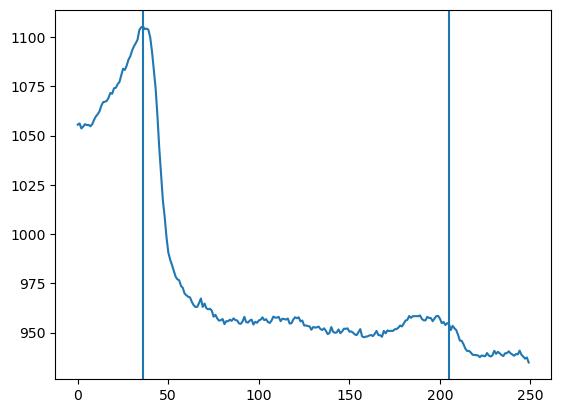

In [44]:
fig, ax = plt.subplots()
brightness_right = jwst_image[jwst_center_y, :][750:1000]
ax.plot(np.arange(len(brightness_right)), brightness_right)

first_peak_right = np.argmax(brightness_right)
second_peak_right = len(brightness_right) - 100 + np.argmax(brightness_right[-100:])
second_peak_right = 205

ax.axvline(first_peak_right)
ax.axvline(second_peak_right)

delta_pixel_right = second_peak_right - first_peak_right

delta_angle_right = delta_pixel_right * jwst_pscale  # mas

delta_year_right = delta_angle_right / right_ridge_expansion
print(f"Period estimate from right ridge shell separation and VISIR expansion is {delta_year_right:.2f} years.")